In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from nscl.models.embedding.attribute_embedding_space import *
from nscl.models.embedding.relation_embedding_space import *
from nscl.models.reasoning.reasoning_module import ReasoningModule
from nscl.datasets.clevr_definition import *
from nscl.datasets.question import Question, Program
from torch import optim

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
# dataset info
input_dim = 128
embedding_dim = 16
size_id = {'big':0, 'small':1}
id_size = {0:'big', 1:'small'}
color_id = {'red':0, 'green':1, 'blue':2}
id_color = {0:'red', 1:'green', 2:'blue'}
definitions = {'size': list(id_size.values()), 'color':list(id_color.values())}
definitions

{'size': ['big', 'small'], 'color': ['red', 'green', 'blue']}

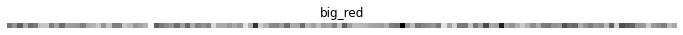

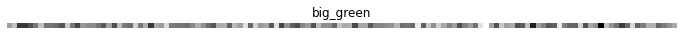

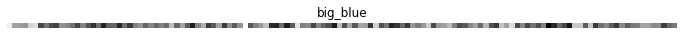

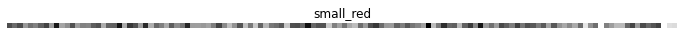

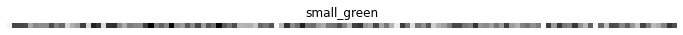

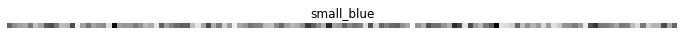

In [3]:
# synthetic data
all_features = {}
for size in definitions['size']:
    for color in definitions['color']:
        all_features[f'{size}_{color}'] = torch.randn((1,input_dim))

for attributes, features in all_features.items():
    plt.figure(figsize=(12,1))
    plt.axis("off")
    plt.title(f'{attributes}')
    plt.imshow(features, cmap='gray')

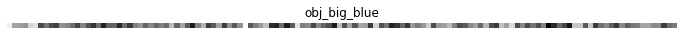

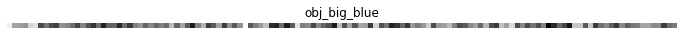

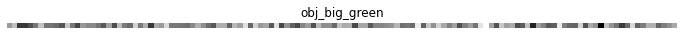

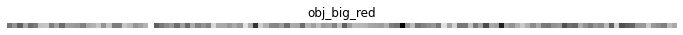

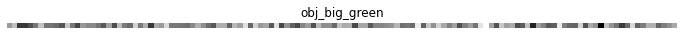

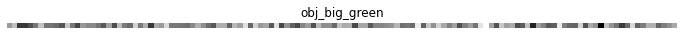

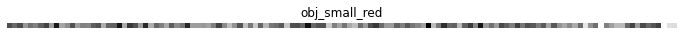

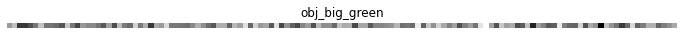

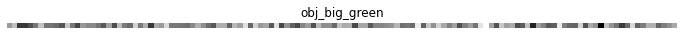

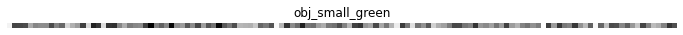

In [4]:
LENGTH = 1000
class MyDataset(Dataset):
    def __init__(self, all_features):
        self.all_features = all_features

    def __getitem__(self, index):
        size_idx = int(index / len(size_id)) % len(size_id)
        color_idx = index % len(color_id)
        features = self.all_features[f'{id_size[size_idx]}_{id_color[color_idx]}']
        labels = torch.tensor([size_idx, color_idx], dtype=int)
        return features, labels

    def __len__(self):
        return LENGTH

dataset = MyDataset(all_features)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True, drop_last=True)
for features, attributes in dataloader:
    for i, (feature, attribute) in enumerate(zip(features, attributes)):
        plt.figure(figsize=(12,1))
        plt.axis("off")
        plt.title(f'obj_{id_size[attribute[0].item()]}_{id_color[attribute[1].item()]}')
        plt.imshow(feature, cmap='gray')
    break

In [5]:
# Embedding space
attribute_es = AttributeEmbeddingSpace(definitions, input_dim, embedding_dim)
relation_es = RelationEmbeddingSpace()
print(attribute_es)

num_epoch = 10
dataset = MyDataset(all_features)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, drop_last=True)
loss_function = nn.MSELoss()
optimiser = optim.Adam(attribute_es.parameters(), lr=0.01)

for i in range(num_epoch):
    for features, attributes in dataloader:
        optimiser.zero_grad()
        for feature, (size_idx, color_idx) in zip(features, attributes):
            size = id_size[size_idx.item()]
            color = id_color[color_idx.item()]
            size_conf = attribute_es.similarity(feature, size)
            color_conf = attribute_es.similarity(feature, color)
            conf = torch.cat([size_conf, color_conf])
            loss = loss_function(conf, torch.tensor([1., 1.]))
            loss.backward()
        optimiser.step()

AttributeEmbeddingSpace(
  (attribute_operators): Module(
    (size): AttributeOperator(
      (map): Linear(in_features=128, out_features=16, bias=True)
    )
    (color): AttributeOperator(
      (map): Linear(in_features=128, out_features=16, bias=True)
    )
  )
  (concept_embeddings): Module(
    (big): ConceptEmbedding()
    (small): ConceptEmbedding()
    (red): ConceptEmbedding()
    (green): ConceptEmbedding()
    (blue): ConceptEmbedding()
  )
)


In [6]:
# Verify accuracy
all_concepts = ['big', 'small', 'red', 'green', 'blue']
obj_keys = ['big_red', 'small_blue', 'big_green', 'small_red', 'small_green']
objects = {k:all_features[k] for k in obj_keys}

for key, obj in objects.items():
    print(f'attributes: {key}')
    for c in all_concepts:
        print(f'sim({c}): {attribute_es.similarity(obj, c).data.item()}')
    print()

attributes: big_red
sim(big): 0.9961569905281067
sim(small): 0.044578634202480316
sim(red): 0.9889770150184631
sim(green): 0.04683752730488777
sim(blue): 0.0011061049299314618

attributes: small_blue
sim(big): 0.00980523694306612
sim(small): 0.9963905215263367
sim(red): 0.001243139966391027
sim(green): 0.9083071351051331
sim(blue): 0.9921935796737671

attributes: big_green
sim(big): 0.9956146478652954
sim(small): 0.006112210918217897
sim(red): 0.00436734315007925
sim(green): 0.9878737330436707
sim(blue): 0.2986607849597931

attributes: small_red
sim(big): 0.0018087450880557299
sim(small): 0.9870340824127197
sim(red): 0.9966213703155518
sim(green): 0.0023743470665067434
sim(blue): 0.44867244362831116

attributes: small_green
sim(big): 0.13223977386951447
sim(small): 0.9899302124977112
sim(red): 0.01978924684226513
sim(green): 0.9888278245925903
sim(blue): 0.014124386012554169



In [7]:
def gen_question(programs):
    q = {}
    q['image_index'] = -1
    q['image_filename'] = ''
    q['question_index'] = -1
    q['question_family_index'] = -1
    q['split'] = ''
    q['answer'] = ''
    q['question'] = ''
    q['program'] = programs
    return Question(q)

def program(operator, value_inputs=[], input_ids=[]):
    p = {}
    p['function'] = operator
    p['inputs'] = input_ids
    p['value_inputs'] = value_inputs
    return p



In [9]:
reasoning_module = ReasoningModule(definitions, input_dim, embedding_dim)
reasoning_module.attribute_space = attribute_es

# Generate scenes
# scene_0 = [small_red, big_blue]
# scene_1 = [small_green, big_blue]
# scene_2 = [small_red, big_green]
# scene_3 = [big_red, small_red]
scenes = []
scenes.append(torch.cat([all_features['small_red'], all_features['big_blue']]))
scenes.append(torch.cat([all_features['small_green'], all_features['big_blue']]))
scenes.append(torch.cat([all_features['small_red'], all_features['big_green']]))
scenes.append(torch.cat([all_features['big_red'], all_features['small_red']]))

# Generate question
# q_0 = What's the color of small object
# q_1 = What's the size of green object
# q_2 = Is there a red object
# q_3 = How many red objects
# q_4 = Is the small object and big object has the same color
questions = []
programs = [program('scene'),
            program('filter_size',value_inputs=['small'],input_ids=[0]),
            program('unique',input_ids=[1]),
            program('query_color',input_ids=[2])]
questions.append(gen_question(programs))
programs = [program('scene'),
            program('filter_color',value_inputs=['green'],input_ids=[0]),
            program('unique',input_ids=[1]),
            program('query_size',input_ids=[2])]
questions.append(gen_question(programs))
programs = [program('scene'),
            program('filter_color',value_inputs=['red'],input_ids=[0]),
            program('exist',input_ids=[1])]
questions.append(gen_question(programs))
programs = [program('scene'),
            program('filter_color',value_inputs=['red'],input_ids=[0]),
            program('count',input_ids=[1])]
questions.append(gen_question(programs))
programs = [program('scene'),
            program('filter_size',value_inputs=['small'],input_ids=[0]),
            program('unique',input_ids=[1]),
            program('query_color',input_ids=[2]),
            program('filter_size',value_inputs=['big'],input_ids=[0]),
            program('unique',input_ids=[4]),
            program('query_color',input_ids=[5]),
            program('equal_color',input_ids=[3,6])]
questions.append(gen_question(programs))

print(reasoning_module(scenes[0], scenes[0], questions[0])) # Query
print(reasoning_module(scenes[1], scenes[1], questions[1])) # Query
print(reasoning_module(scenes[0], scenes[0], questions[2])) # Exist
print(reasoning_module(scenes[1], scenes[1], questions[2])) # Exist
print(reasoning_module(scenes[3], scenes[3], questions[2])) # Exist
print(reasoning_module(scenes[3], scenes[3], questions[3])) # Count
print(reasoning_module(scenes[0], scenes[0], questions[3])) # Count
print(reasoning_module(scenes[1], scenes[1], questions[3])) # Count
print(reasoning_module(scenes[3], scenes[3], questions[4])) # AttributeEqual
print(reasoning_module(scenes[1], scenes[1], questions[4])) # AttributeEqual

tensor([0.0050, 0.1303, 0.8647], grad_fn=<DivBackward0>)
tensor([0.1178, 0.8822], grad_fn=<DivBackward0>)
tensor(0.9966, grad_fn=<MaxBackward1>)
tensor(0.0198, grad_fn=<MaxBackward1>)
tensor(0.9966, grad_fn=<MaxBackward1>)
tensor(1.9856, grad_fn=<SumBackward0>)
tensor(1.0023, grad_fn=<SumBackward0>)
tensor(0.0255, grad_fn=<SumBackward0>)
tensor(0.9117, grad_fn=<SumBackward0>)
tensor(0.7648, grad_fn=<SumBackward0>)


NameError: name 'functional' is not defined